In [85]:
from functools import partial

import numpy as np
import scipy.constants as _c
from sympy.physics.hydrogen import Psi_nlm
from sympy import conjugate, oo, integrate, Symbol, sin, cos, pi, N, I, sqrt
import matplotlib.pyplot as plt

from onix.models.schiff import MeasurementSettings, Atom, NewPhysicsSensitivities
from onix.units import ureg, Q_

## Effective electric field

There are three calculations of the static polarizability of the 7F0 state in vacuum. 
* https://doi.org/10.1103/PhysRevA.101.042504: Table III, 7 a.u.
* https://doi.org/10.1016/j.chemphys.2004.10.014, Table 6, 0.823 a.u. (1.11 a.u. in ref [3] within)

However, no calculation for the excited state is present and no calculation of the Eu:YSO is present. Below we present three methods estimating the electric field on Eu atom along the D1 direction.

In [2]:
def polarizability_atomic_unit_to_SI(polarizability_au):
    """Converts a polarizability from atomic units to SI units.

    See https://link.aps.org/doi/10.1103/PhysRevA.83.012503, text below Eq. 13.
    """
    a0 = _c.physical_constants["Bohr radius"][0]
    polarizability_au_to_SI = 4 * np.pi * _c.epsilon_0 * a0**3
    return polarizability_au * polarizability_au_to_SI * ureg.A**2 * ureg.s**4 / ureg.kg 

def Stark_shift_coefficient(polarizability_SI, electric_field):
    return polarizability_SI * electric_field * 2

def Stark_shift(polarizability_SI, electric_field):
    return polarizability_SI * electric_field ** 2

### from the Stark shift coefficient and a conservative 100 a.u. differential scalar static polarizability.

If we assume the differential scalar static polarizability between the 5D0 and 7F0 states in Eu:YSO could be large, say 100 a.u.

In [3]:
measured_Stark_coefficient = 27.18 * ureg.kHz / (ureg.V / ureg.cm)
dssp_au = 100  # very conservative
dssp_SI = polarizability_atomic_unit_to_SI(dssp_au)
electric_field = 0.547 * ureg.MV / ureg.cm
Stark_coefficient_from_dssp = Stark_shift_coefficient(dssp_SI, electric_field) / ureg.planck_constant
print(f"The calculated Stark shift coefficient is {Stark_coefficient_from_dssp.to('kHz/(V/cm)'):.1f} at {electric_field} and {dssp_au} a.u. DSSP.")
print(f"The measured Stark shift coefficient is {measured_Stark_coefficient.to('kHz/(V/cm)'):.1f}.")

The calculated Stark shift coefficient is 27.2 centimeter * kilohertz / volt at 0.547 megavolt / centimeter and 100 a.u. DSSP.
The measured Stark shift coefficient is 27.2 centimeter * kilohertz / volt.


### from the Stark shift coefficient and an optimistic 1 a.u. differential scalar static polarizability.

If we assume the differential scalar static polarizability between the 5D0 and 7F0 states in Eu:YSO is comparable to the 7F0 polarizability in vacuum, say 1 a.u.

In [4]:
measured_Stark_coefficient = 27.18 * ureg.kHz / (ureg.V / ureg.cm)
dssp_au = 1  # reasonable
dssp_SI = polarizability_atomic_unit_to_SI(dssp_au)
electric_field = 54.7 * ureg.MV / ureg.cm
Stark_coefficient_from_dssp = Stark_shift_coefficient(dssp_SI, electric_field) / ureg.planck_constant
print(f"The calculated Stark shift coefficient is {Stark_coefficient_from_dssp.to('kHz/(V/cm)'):.1f} at {electric_field} and {dssp_au} a.u. DSSP.")
print(f"The measured Stark shift coefficient is {measured_Stark_coefficient.to('kHz/(V/cm)'):.1f}.")

The calculated Stark shift coefficient is 27.2 centimeter * kilohertz / volt at 54.7 megavolt / centimeter and 1 a.u. DSSP.
The measured Stark shift coefficient is 27.2 centimeter * kilohertz / volt.


In [5]:
# from the optical Stark shift from free-space Eu transition frequency
Eu_optical_free_space = 17270 * ureg.cm**-1 * ureg.c * ureg.planck_constant
Eu_optical_YSO = 516847.5 * ureg.GHz * ureg.planck_constant
Eu_Stark_shift = Eu_optical_YSO - Eu_optical_free_space
print(f"The calculated Stark shift is {(Stark_shift(dssp_SI, electric_field) / ureg.planck_constant).to('GHz'):.0f} at {electric_field} and {dssp_au} a.u. DSSP.")
print(f"The actual Stark shift is {Eu_Stark_shift / ureg.planck_constant:.0f}.")

The calculated Stark shift is 745 gigahertz at 54.7 megavolt / centimeter and 1 a.u. DSSP.
The actual Stark shift is -894 gigahertz.


In [6]:
# select DSSP and electric field so that both the hyperfine splitting and Stark shift coefficient agrees with experiment.
# This is only approximate as the electric field affects both the D and E terms in the Q tensor,
# so the splitting is not perfectly quadratic with the electric field.
Eu_Stark_ab = 119 * ureg.MHz * ureg.planck_constant
Eu_Stark_coefficient_ab = 1.0 * ureg.Hz * ureg.cm / ureg.V * 2.58  # PhysRevLett.113.157603, scaled to 153Eu
dssp_ab_au = 0.00005
dssp_ab_SI = polarizability_atomic_unit_to_SI(dssp_ab_au)
electric_field_ab = 100 * ureg.MV / ureg.cm
Stark_coefficient_from_dssp_ab = Stark_shift_coefficient(dssp_ab_SI, electric_field_ab) / ureg.planck_constant
print(f"The calculated Stark shift coefficient is {Stark_coefficient_from_dssp_ab.to('Hz/(V/cm)'):.1f} at {electric_field_ab} and {dssp_ab_au} a.u. DSSP.")
print(f"The measured Stark shift coefficient is {Eu_Stark_coefficient_ab.to('Hz/(V/cm)'):.1f}.")
print(f"The calculated Stark shift is {(Stark_shift(dssp_ab_SI, electric_field_ab) / ureg.planck_constant).to('MHz'):.0f} at {electric_field_ab} and {dssp_ab_au} a.u. DSSP.")
print(f"The actual Stark shift is {Eu_Stark_ab / ureg.planck_constant}.")

The calculated Stark shift coefficient is 2.5 centimeter * hertz / volt at 100.0 megavolt / centimeter and 5e-05 a.u. DSSP.
The measured Stark shift coefficient is 2.6 centimeter * hertz / volt.
The calculated Stark shift is 124 megahertz at 100.0 megavolt / centimeter and 5e-05 a.u. DSSP.
The actual Stark shift is 119.0 megahertz.


In [7]:
# select DSSP and electric field so that both the hyperfine splitting and Stark shift coefficient agrees with experiment.
# This is only approximate as the electric field affects both the D and E terms in the Q tensor,
# so the splitting is not perfectly quadratic with the electric field.
Eu_Stark_bc = 89 * ureg.MHz * ureg.planck_constant
Eu_Stark_coefficient_bc = 0.43 * ureg.Hz * ureg.cm / ureg.V * 2.58  # PhysRevLett.113.157603, scaled to 153Eu
dssp_bc_au = 0.000015
dssp_bc_SI = polarizability_atomic_unit_to_SI(dssp_bc_au)
electric_field_bc = 150 * ureg.MV / ureg.cm
Stark_coefficient_from_dssp_bc = Stark_shift_coefficient(dssp_bc_SI, electric_field_bc) / ureg.planck_constant
print(f"The calculated Stark shift coefficient is {Stark_coefficient_from_dssp_bc.to('Hz/(V/cm)'):.1f} at {electric_field_bc} and {dssp_bc_au} a.u. DSSP.")
print(f"The measured Stark shift coefficient is {Eu_Stark_coefficient_bc.to('Hz/(V/cm)'):.1f}.")
print(f"The calculated Stark shift is {(Stark_shift(dssp_bc_SI, electric_field_bc) / ureg.planck_constant).to('MHz'):.0f} at {electric_field_bc} and {dssp_bc_au} a.u. DSSP.")
print(f"The actual Stark shift is {Eu_Stark_bc / ureg.planck_constant}.")

The calculated Stark shift coefficient is 1.1 centimeter * hertz / volt at 150.0 megavolt / centimeter and 1.5e-05 a.u. DSSP.
The measured Stark shift coefficient is 1.1 centimeter * hertz / volt.
The calculated Stark shift is 84 megahertz at 150.0 megavolt / centimeter and 1.5e-05 a.u. DSSP.
The actual Stark shift is 89.0 megahertz.


### from linear and quadratic optical Stark shift coefficients

Measurement of the linear Stark shift coefficient and constraints on the quadratic Stark shift coefficient between 5D0 and 7F0 was done in YSO: https://doi.org/10.1063/5.0025356. Assuming that the Stark shift is purely quadratic, we can calculate a lower bound on the electric field using the linear and quadratic Stark shift coefficients. Namely, the electric field $E = \beta/(2\alpha)$, where $\beta$ is the linear Stark shift coefficient and $\alpha$ is the quadratic Stark shift coefficient.

In [8]:
measured_linear_Stark_coefficient_D1 = 27.18 * ureg.kHz / (ureg.V / ureg.cm)
measured_quadratic_Stark_coefficient_D1_bound = 3e-3 * ureg.Hz / (ureg.V / ureg.cm) ** 2
print(f"Minimum field calculated along D1 is {(measured_linear_Stark_coefficient_D1 / measured_quadratic_Stark_coefficient_D1_bound / 2).to('MV/cm'):.1f}.")

measured_linear_Stark_coefficient_D2 = 18.61 * ureg.kHz / (ureg.V / ureg.cm)
measured_quadratic_Stark_coefficient_D2_bound = 1e-3 * ureg.Hz / (ureg.V / ureg.cm) ** 2
print(f"Minimum field calculated along D2 is {(measured_linear_Stark_coefficient_D2 / measured_quadratic_Stark_coefficient_D2_bound / 2).to('MV/cm'):.1f}.")

Minimum field calculated along D1 is 4.5 megavolt / centimeter.
Minimum field calculated along D2 is 9.3 megavolt / centimeter.


Since the two numbers here are lower bounds, and we think the field along D1 should be larger than the field along D2, so we estimate the effective field along D1 to be greater than 10 MV/cm.

Dependent on the method and approximation used, the result effective E field range from 0.5 to 50 MV / cm. The most reasonable approximation is probably using the measured linear and quadratic shift coefficients, so we estimate the effective field to be 10 MV/cm in calculations below.

### Electric field along the nuclear spin

In [9]:
effective_E_field = 10 * ureg.MV / ureg.cm
hat_I_dot_hat_n_b = 0.3  # b state
effective_E_field_along_I_b = effective_E_field * hat_I_dot_hat_n_b

## Europium atom

In [10]:
# Table IV of Flambaum and Dzuba PRA 101, 042504 (2020).
# K_Z from the EDM sensitivity normalized to 225Ra value.
K_S = 3.7
K_Z = abs(0.33 / -8.25)
eu153_triple_charged = Atom(K_S, K_Z, effective_E_field_along_I_b)

In [11]:
b_bbar_frequency_uncertainty = 2 * ureg.mHz
# factor of 2 from b and bbar state opposite sensivitity
theta_QCD_bound = (b_bbar_frequency_uncertainty / (eu153_triple_charged.frequency_shift_in_theta_QCD * 2)).to("").magnitude

In [12]:
sensitivity = NewPhysicsSensitivities(theta_QCD_bound)
print(f"With {b_bbar_frequency_uncertainty} b - bbar splitting measurement uncertainty:")
print(f"theta_QCD is constrained at {theta_QCD_bound:.1e}.")
print("\\tilta{d}_u - \\tilta{d}_d chromo EDM difference is constrained at " + f"{sensitivity.chromo_edm_difference:.1e}.")
print("New physics particle mass is constrained at above " + f"{sensitivity.new_particle_mass:.1e} THz.")

With 2 millihertz b - bbar splitting measurement uncertainty:
theta_QCD is constrained at 1.0e-07.
\tilta{d}_u - \tilta{d}_d chromo EDM difference is constrained at 1.9e-24 centimeter.
New physics particle mass is constrained at above 3.4e-01 THz.


## Estimation of the molecular enhancement from EuO charge transfer

In [96]:
# https://chem.libretexts.org/Courses/Saint_Marys_College_Notre_Dame_IN/CHEM_342%3A_Bio-inorganic_Chemistry/Readings/Week_1%3A_Analysis_of_Periodic_Trends/1.1%3A_Concepts_and_principles_that_explain_periodic_trends/1.1.2%3A_Effective_Nuclear_Charge

def Psi_H_1s(r, theta, phi):
    Z = 1
    n = 1
    l = 0
    m = 0
    return Psi_nlm(n, l, m, r, phi, theta, Z)
    
def Psi_H_2s(r, theta, phi):
    Z = 1
    n = 2
    l = 0
    m = 0
    return Psi_nlm(n, l, m, r, phi, theta, Z)
    
def Psi_H_2p(m, r, theta, phi):
    Z = 1
    n = 2
    l = 1
    return Psi_nlm(n, l, m, r, phi, theta, Z)
    
def Psi_Eu3p_4f(m, r, theta, phi):
    e_5s = 2
    e_5p = 6
    Z = e_5s + e_5p + 1
    n = 4
    l = 3
    return Psi_nlm(n, l, m, r, phi, theta, Z)

def Psi_O2m_nd(n, m, r, theta, phi):
    # the other oxygen electron comes from another bond
    Z = 1
    l = 2
    return Psi_nlm(n, l, m, r, phi, theta, Z)

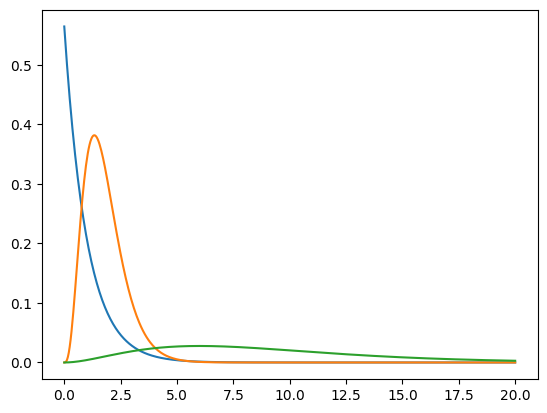

In [97]:
fig, ax = plt.subplots()
rs = np.linspace(0, 20, 500)
ax.plot(rs, [Psi_H_1s(r, 0, 0) for r in rs])
ax.plot(rs, [Psi_Eu3p_4f(0, r, 0, 0) for r in rs])
ax.plot(rs, [Psi_O2m_nd(3, 0, r, 0, 0) for r in rs])
plt.show()

In [107]:
r = Symbol("r", positive=True)
theta = Symbol("theta", real=True)
phi = Symbol("phi", real=True)

E1_z = r * cos(theta)
E1_p = (r * sin(theta) * cos(phi) + r * sin(theta) * sin(phi) * I) / sqrt(2)
E1_m = (r * sin(theta) * cos(phi) - r * sin(theta) * sin(phi) * I) / sqrt(2)

def braket_integrate(Psi_1, Psi_2, operator):
    return integrate(Psi_1(r, theta, phi) * conjugate(Psi_2(r, theta, phi)) * r**2 * sin(theta) * operator, (r, 0, oo), (phi, 0, 2*pi), (theta, 0, pi))

Psi_Eu = partial(Psi_Eu3p_4f, 2)
n_hole = 3
squared_braket_sum = 0
for kk, operator in enumerate([E1_z, E1_p, E1_m]):
    for m in [-2, -1, 0, 1, 2]:
        braket = braket_integrate(Psi_Eu, partial(Psi_O2m_nd, n_hole, m), operator)
        if braket != 0:
            if kk == 0:
                operator_name = "z"
            elif kk == 1:
                operator_name = "+"
            elif kk == 2:
                operator_name = "-"
            else:
                operator_name = "wrong"
            print(m, operator_name, braket)
            squared_braket_sum += braket ** 2
print(N(squared_braket_sum))

2 z 1253826625536*sqrt(6)/26439622160671
1 - -2507653251072*sqrt(3)/26439622160671
0.0404796726813210


## Sanity check: Hydrogen transition dipole MEs

In [81]:
# check: H 1s -> 1s
print(N(braket_integrate(Psi_H_1s, Psi_H_1s, r * cos(theta))))

0


In [80]:
# check: H 1s -> 2s
print(N(braket_integrate(Psi_H_1s, Psi_H_2s, r * cos(theta))))

0


In [86]:
# check: H 1s -> 2p (m=0)
print(N(braket_integrate(Psi_H_1s, partial(Psi_H_2p, 0), E1_z)))
print(N(braket_integrate(Psi_H_1s, partial(Psi_H_2p, 0), E1_p)))
print(N(braket_integrate(Psi_H_1s, partial(Psi_H_2p, 0), E1_m)))

0.744935539027803
0
0


In [88]:
# check: H 1s -> 2p (m=1)
print(N(braket_integrate(Psi_H_1s, partial(Psi_H_2p, 1), E1_z)))
print(N(braket_integrate(Psi_H_1s, partial(Psi_H_2p, 1), E1_p)))
print(N(braket_integrate(Psi_H_1s, partial(Psi_H_2p, 1), E1_m)))

0
-0.744935539027803
0


In [89]:
# check: H 1s -> 2p (m=-1)
print(N(braket_integrate(Psi_H_1s, partial(Psi_H_2p, -1), E1_z)))
print(N(braket_integrate(Psi_H_1s, partial(Psi_H_2p, -1), E1_p)))
print(N(braket_integrate(Psi_H_1s, partial(Psi_H_2p, -1), E1_m)))

0
0
0.744935539027803
